## 코로나 확진 예방
- 해외유입확진자에 대한 시계열(Time-Series) 데이터를 사용하여 예측 모델 만들기
- 가까운 미래에 발생하는 해외유입 사례를 예측
- 14일의 미래값을 예측하는 것이 프로젝트의 목표
- 모델링에는 PyTorch 기반 LSTM 모델

- https://data-panic.tistory.com/33 참고

#### 1. Load libraries

In [5]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc

#### 2. Load data

In [32]:
df = pd.read_csv('final_0507.csv')
df.drop(["Unnamed: 0"], axis = 1, inplace = True)
df

,Date,MM_conf,LA_conf,NL_conf,PH_conf,RU_conf,KR,TW_conf,US_conf,AE_conf,...,DE_roam,JP_roam,TH_roam,VN_roam,US_roam,CN_roam,news,covid_tr,coro_tr,target
0,2020-01-22,0,0,0,0,0,0,0,0,0,...,450,2717,1382,2592,701,2453,430.0,0.0,1.0,0.0
1,2020-01-23,0,0,0,0,0,0,0,0,0,...,476,2520,1259,2338,943,2188,452.0,0.0,5.0,0.0
2,2020-01-24,0,0,0,0,0,1,2,1,0,...,564,2448,1069,2251,864,1698,421.0,0.0,5.0,1.0
3,2020-01-25,0,0,0,0,0,0,0,0,0,...,395,2542,1031,2336,828,1403,506.0,0.0,7.0,0.0
4,2020-01-26,0,0,0,0,0,1,1,3,0,...,377,4823,1477,2695,900,2508,552.0,0.0,8.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2020-05-01,0,0,476,284,7933,6,0,34037,557,...,4,98,22,43,52,153,1104.0,48.0,18.0,8.0
101,2020-05-02,0,0,445,156,9623,13,3,29078,561,...,31,155,15,15,108,85,732.0,43.0,18.0,8.0
102,2020-05-03,4,0,335,295,10633,8,4,25501,564,...,15,154,20,48,116,146,821.0,55.0,18.0,10.0
103,2020-05-04,6,0,199,262,10581,3,2,22335,567,...,32,131,12,91,72,97,1331.0,30.0,17.0,8.0


- Date setting

In [33]:
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)
df

,MM_conf,LA_conf,NL_conf,PH_conf,RU_conf,KR,TW_conf,US_conf,AE_conf,GB_conf,...,DE_roam,JP_roam,TH_roam,VN_roam,US_roam,CN_roam,news,covid_tr,coro_tr,target
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,450,2717,1382,2592,701,2453,430.0,0.0,1.0,0.0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,476,2520,1259,2338,943,2188,452.0,0.0,5.0,0.0
2020-01-24,0,0,0,0,0,1,2,1,0,0,...,564,2448,1069,2251,864,1698,421.0,0.0,5.0,1.0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,395,2542,1031,2336,828,1403,506.0,0.0,7.0,0.0
2020-01-26,0,0,0,0,0,1,1,3,0,0,...,377,4823,1477,2695,900,2508,552.0,0.0,8.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-01,0,0,476,284,7933,6,0,34037,557,6204,...,4,98,22,43,52,153,1104.0,48.0,18.0,8.0
2020-05-02,0,0,445,156,9623,13,3,29078,561,4815,...,31,155,15,15,108,85,732.0,43.0,18.0,8.0
2020-05-03,4,0,335,295,10633,8,4,25501,564,4342,...,15,154,20,48,116,146,821.0,55.0,18.0,10.0


- 변수명
    - Date : 날짜(index)
    - 국가코드_conf : 해당 국가의 일별 확진자 수
    - 국가코드_roam : 해당 국가로 부터 한국으로 들어온 일별 로밍 이용자 수
    - KR : 국내 일별 확진자 수 (지역사회)
    - news : 코로나 관련 해외 뉴스 일별 갯수
    - covid_tr : 'covid' 키워드로 검색한 구글 트렌드 지수
    - coro_tr : 'corona' 키워드로 검색한 구글 트렌드 지수
    - target(해외유입확진자)

In [34]:
lag_col= list(df.columns)
lag_col

['MM_conf',
 'LA_conf',
 'NL_conf',
 'PH_conf',
 'RU_conf',
 'KR',
 'TW_conf',
 'US_conf',
 'AE_conf',
 'GB_conf',
 'VN_conf',
 'AU_conf',
 'AT_conf',
 'KH_conf',
 'CA_conf',
 'CN_conf',
 'HR_conf',
 'CZ_conf',
 'EG_conf',
 'FI_conf',
 'FR_conf',
 'DE_conf',
 'HU_conf',
 'IN_conf',
 'ID_conf',
 'IL_conf',
 'IT_conf',
 'JP_conf',
 'MY_conf',
 'MX_conf',
 'MN_conf',
 'NZ_conf',
 'PL_conf',
 'PT_conf',
 'QA_conf',
 'SG_conf',
 'ES_conf',
 'CH_conf',
 'TH_conf',
 'TR_conf',
 'HR_roam',
 'MN_roam',
 'PL_roam',
 'MM_roam',
 'QA_roam',
 'EG_roam',
 'MX_roam',
 'LA_roam',
 'FI_roam',
 'HU_roam',
 'KH_roam',
 'IL_roam',
 'CH_roam',
 'PT_roam',
 'NL_roam',
 'TW_roam',
 'IN_roam',
 'NZ_roam',
 'CZ_roam',
 'CA_roam',
 'AT_roam',
 'RU_roam',
 'SG_roam',
 'AU_roam',
 'AE_roam',
 'ID_roam',
 'TR_roam',
 'GB_roam',
 'PH_roam',
 'MY_roam',
 'IT_roam',
 'ES_roam',
 'FR_roam',
 'DE_roam',
 'JP_roam',
 'TH_roam',
 'VN_roam',
 'US_roam',
 'CN_roam',
 'news',
 'covid_tr',
 'coro_tr',
 'target']

- 모든 변수에 시차(LAG) 생성
    - 각 변수들에 3개의 시차 변수 만들고 생성으로 인한 NAN 값은 통째로 날리기

In [35]:
lag_amount = 3

for col in lag_col:
    for i in range(lag_amount):
        df['{0}_lag{1}'.format(col,i+1)] = df['{}'.format(col)].shift(i+1)
    
df.dropna(inplace=True)
df

,MM_conf,LA_conf,NL_conf,PH_conf,RU_conf,KR,TW_conf,US_conf,AE_conf,GB_conf,...,news_lag3,covid_tr_lag1,covid_tr_lag2,covid_tr_lag3,coro_tr_lag1,coro_tr_lag2,coro_tr_lag3,target_lag1,target_lag2,target_lag3
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,430.0,0.0,0.0,0.0,5.0,5.0,1.0,1.0,0.0,0.0
2020-01-26,0,0,0,0,0,1,1,3,0,0,...,452.0,0.0,0.0,0.0,7.0,5.0,5.0,0.0,1.0,0.0
2020-01-27,0,0,0,0,0,1,1,0,0,0,...,421.0,0.0,0.0,0.0,8.0,7.0,5.0,1.0,0.0,1.0
2020-01-28,0,0,0,0,0,0,3,0,0,0,...,506.0,0.0,0.0,0.0,13.0,8.0,7.0,1.0,1.0,0.0
2020-01-29,0,0,0,0,0,0,0,0,4,0,...,552.0,0.0,0.0,0.0,17.0,13.0,8.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-01,0,0,476,284,7933,6,0,34037,557,6204,...,1763.0,43.0,63.0,59.0,18.0,18.0,18.0,4.0,5.0,12.0
2020-05-02,0,0,445,156,9623,13,3,29078,561,4815,...,1117.0,48.0,43.0,63.0,18.0,18.0,18.0,8.0,4.0,5.0
2020-05-03,4,0,335,295,10633,8,4,25501,564,4342,...,1266.0,43.0,48.0,43.0,18.0,18.0,18.0,8.0,8.0,4.0


In [36]:
df.isnull().sum()

MM_conf         0
LA_conf         0
NL_conf         0
PH_conf         0
RU_conf         0
               ..
coro_tr_lag2    0
coro_tr_lag3    0
target_lag1     0
target_lag2     0
target_lag3     0
Length: 332, dtype: int64

#### 3. data Exploration

In [37]:
print("total shape: {}".format(df.shape))
print("target feature shape: {}".format(df['target'].shape))

total shape: (102, 332)
target feature shape: (102,)


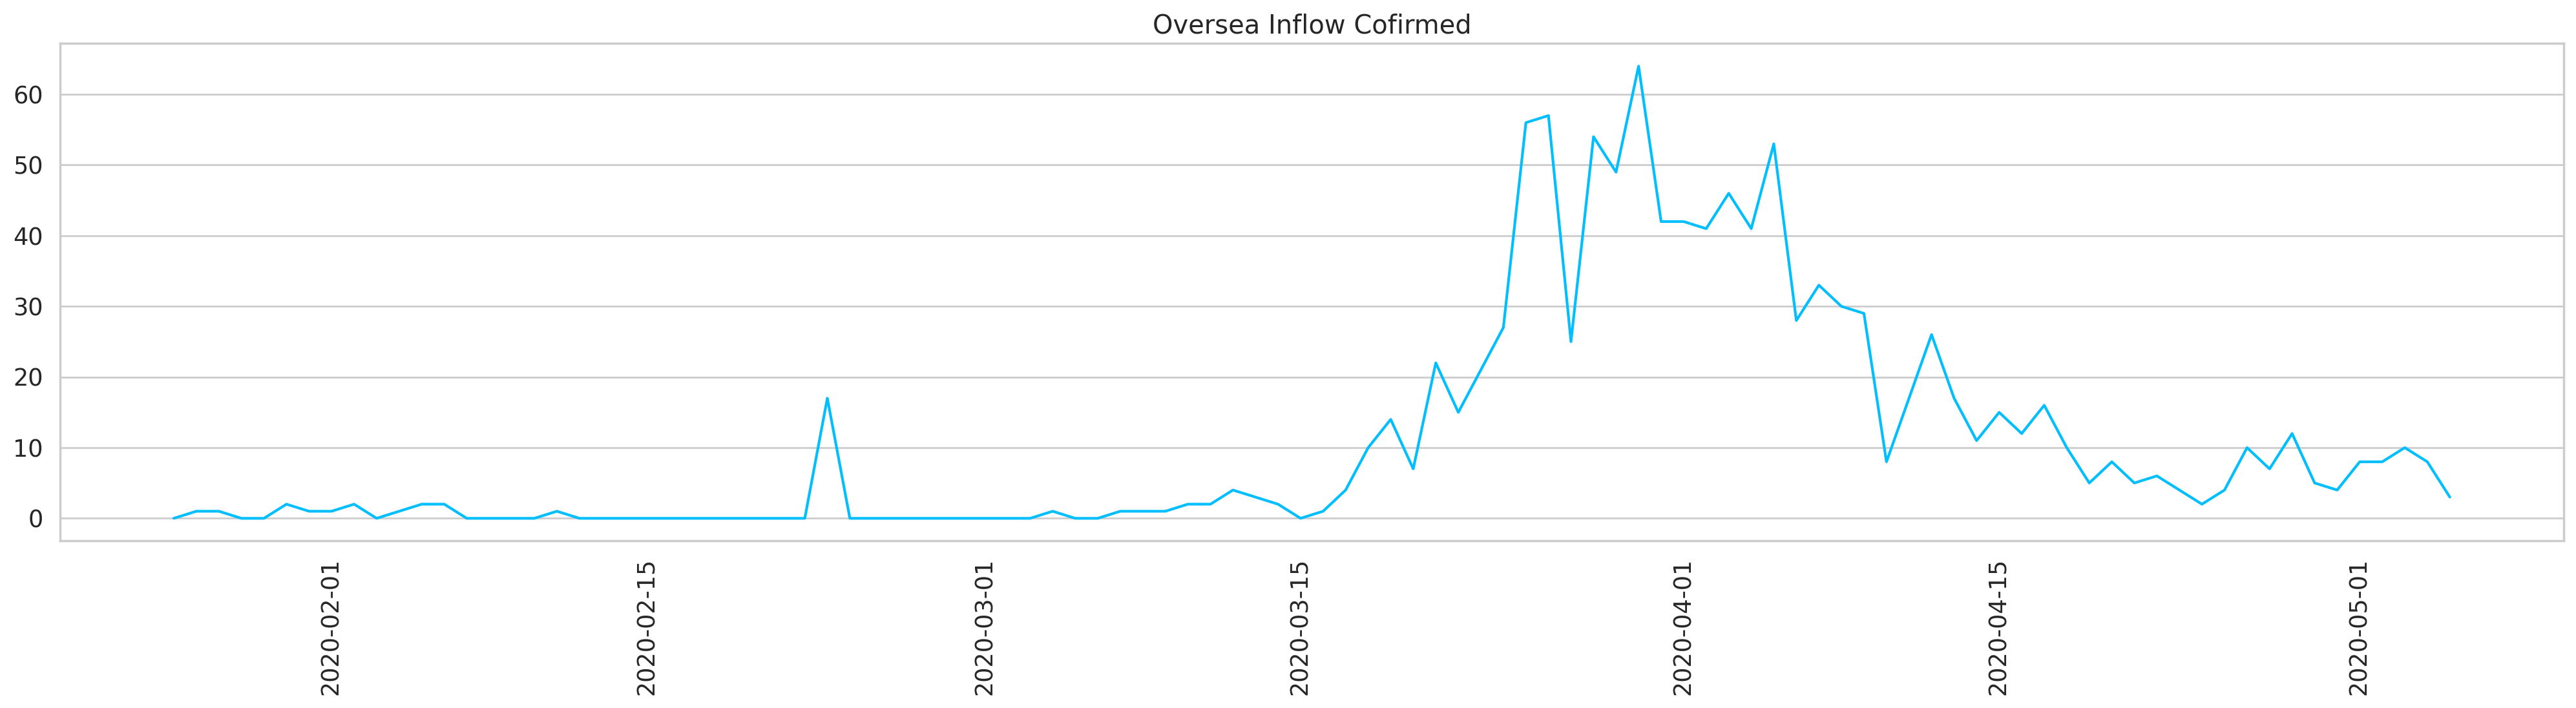

In [38]:
plt.figure(figsize=(25,5))
plt.plot(df['target'])
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')

#### 4. LSTM model

In [49]:
X_cols = list(df.columns)
X_cols.remove('target')

- target(해외유입확진자) 변수를 분리하여 y로 지정해주고 나머지 변수는 X로 지정
- test set의 사이즈는 14로 지정
    - 보통 7:3 정도로 train / test set을 나누지만 2주의 예측값을 산출하는 것이 목표이고 데이터가 적기 때문에 14로 지정

In [51]:
test_data_size = 14

X = df[X_cols]
y = df['target']

- X, y에 스케일링
- Scikit-learn의 MinMaxScaler를 사용
    - 스케일된 데이터를 추후에 다시 inverse scale 해주기 위해 X 데이터와 y데이터 각각 스케일러를 만들어 적용
    - 그 후에 train / test 셋을 구분
    - lstm sequence를 만들어주기 위해 y데이터를 flatten()하여 차원을 줄이기

In [56]:
# MinMaxScaler 스케일링
scaler = MinMaxScaler()


Xscaler = scaler.fit(X)
yscaler = scaler.fit(y.values.reshape(-1,1))

In [58]:
# 스케일링 적용
X = Xscaler.fit_transform(X)
y = yscaler.fit_transform(y.values.reshape(-1,1))

In [77]:
# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()

In [78]:
print("train set : ", X_train.shape)
print("test set : ", X_test.shape)

train set :  (88, 331)
test set :  (14, 331)


- LSTM 을 위한 시퀀스 데이터 형성 함수
    - 모델 안에 들어갈 데이터를 시퀀스 형태로 만들어 주기 위한 함수

In [79]:
def create_sequences1(array, seq_length):
    res = []
    if seq_length == 1:
        for i in range(len(array)):
            tmp=array[i:(i+seq_length)]
            res.append(tmp)
    else:
        for i in range(len(array)-seq_length-1):
            tmp = array[i:(i+seq_length)]
            res.append(tmp)
    return res

- 함수를 사용하여 데이터를 시퀀스형태로 만듦
    - 5개 씩 한 시퀀스로 묶었을 경우
    - X_train을 보면 한 1개의 array에 5개의 데이터가 들어가 있음
    - = 1월 22일 부터 1월 26일까지의 X 데이터가 하나로 묶여서 모델로 들어가는 구조
    - 시퀀스 형태로 만드는 이유는 시계열 데이터의 순서를 학습시키기 위함

In [74]:
seq_length = 5

X_train = create_sequences1(X_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
X_test = create_sequences1(X_test, seq_length)
y_test = create_sequences1(y_test, seq_length)
X_train[:3]

[array([[0.      , 0.      , 0.      , ..., 0.015625, 0.      , 0.      ],
        [0.      , 0.      , 0.      , ..., 0.      , 0.015625, 0.      ],
        [0.      , 0.      , 0.      , ..., 0.015625, 0.      , 0.015625],
        [0.      , 0.      , 0.      , ..., 0.015625, 0.015625, 0.      ],
        [0.      , 0.      , 0.      , ..., 0.      , 0.015625, 0.015625]]),
 array([[0.      , 0.      , 0.      , ..., 0.      , 0.015625, 0.      ],
        [0.      , 0.      , 0.      , ..., 0.015625, 0.      , 0.015625],
        [0.      , 0.      , 0.      , ..., 0.015625, 0.015625, 0.      ],
        [0.      , 0.      , 0.      , ..., 0.      , 0.015625, 0.015625],
        [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.015625]]),
 array([[0.      , 0.      , 0.      , ..., 0.015625, 0.      , 0.015625],
        [0.      , 0.      , 0.      , ..., 0.015625, 0.015625, 0.      ],
        [0.      , 0.      , 0.      , ..., 0.      , 0.015625, 0.015625],
        [0.      , 0.

- 시퀀스를 만들지 않고 사용하려면 seq_length를 1
    - 목표했던 것은 14일 예측하는 것
    - 시퀀스를 만듦으로써 데이터 또한 더 필요
    - 가지고 있는 데이터는 한정되어있기 때문에 시퀀스를 만들지 않고 사용

In [80]:
seq_length = 1

X_train = create_sequences1(X_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
X_test = create_sequences1(X_test, seq_length)
y_test = create_sequences1(y_test, seq_length)
X_train[:3]

[array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.56618726e-02,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         8.55274362e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.64258555e-01,
         1.27659574e-02, 0.00000000e+00, 0.00000000e+00, 1.11111111e-02,
         0.00000000e+00, 9.60047704e-02, 0.00000000e+00, 0.00000000e+00,
         5.10272579e-01, 0.00000000e+00, 1.06382979e-02, 0.00000000e+00,
         5.14705882e-01, 4.52380952e-01, 7.44444444e-01, 5.26717557e-01,
         4.11290323e-01, 8.94736842e-01, 5.45454545e-01, 7.05263158e-01,
         6.11111111e-01, 5.29411765e-01, 4.36194896e-01, 5.92991914e-02,
         7.03703704e-01, 2.09523810e-01, 4.85549133

- PyTorch 모델에 데이터를 올리기 위해 torch.tensor로 변환

In [81]:
# numpy를 tensor로 변환
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [82]:
print("X_train :",(X_train.shape))
print("X_test :",(X_test.shape))
print("y_train :",(y_train.shape))
print("y_test :",(y_test.shape))

X_train : torch.Size([88, 1, 331])
X_test : torch.Size([14, 1, 331])
y_train : torch.Size([88, 1])
y_test : torch.Size([14, 1])


#### 5. LSTM 모델 생성

- LSTM과 Linear로 구성
    - num_layers로 레이어층의 갯수를 설정할 수 있도록 함
    - 데이터가 적고 딥러닝 모델의 크거나 깊지 않으므로 dropout은 따로 주지 않음

In [86]:
# 모델 Clss 생성

class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        #dropout=0.1
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

#### 6. 모델 훈련

- epoch과 learning rate를 파라미터로 설정할 수 있게 함
- loss function으로는 MSELoss
- optimizer로 Adam
    - optimizer에 weight_decay를 설정
- 10 epoch 마다 train과 test의 loss를 출력

In [87]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=250, lr=1e-3):
    loss_fn = torch.nn.MSELoss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {round(loss.item(),4)} test loss: {round(test_loss.item(),4)}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [88]:
# 하이퍼파라미터

n_features=X_train.shape[-1]
n_hidden=64
n_layers=4
lr=1e-4
num_epochs=200

In [89]:
# Training Models
model = CoronaVirusPredictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.1498 test loss: 0.0435
Epoch 10 train loss: 0.1338 test loss: 0.0329
Epoch 20 train loss: 0.1178 test loss: 0.0227
Epoch 30 train loss: 0.1007 test loss: 0.0126
Epoch 40 train loss: 0.0825 test loss: 0.0039
Epoch 50 train loss: 0.065 test loss: 0.0046
Epoch 60 train loss: 0.05 test loss: 0.0306
Epoch 70 train loss: 0.0367 test loss: 0.0759
Epoch 80 train loss: 0.0309 test loss: 0.0922
Epoch 90 train loss: 0.0278 test loss: 0.0668
Epoch 100 train loss: 0.0239 test loss: 0.0459
Epoch 110 train loss: 0.0187 test loss: 0.0252
Epoch 120 train loss: 0.0125 test loss: 0.0074
Epoch 130 train loss: 0.0086 test loss: 0.0025
Epoch 140 train loss: 0.0081 test loss: 0.0039
Epoch 150 train loss: 0.0077 test loss: 0.0033
Epoch 160 train loss: 0.0075 test loss: 0.0026
Epoch 170 train loss: 0.0074 test loss: 0.0026
Epoch 180 train loss: 0.0073 test loss: 0.0026
Epoch 190 train loss: 0.0073 test loss: 0.0027


- 학습 결과
    - loss가 수렴하는 모습을 보면 상당히 비정상적인 것
    - 우선 train보다 test의 loss가 더 낮음
        * 1) train data가 너무 어렵거나 test data가 너무 쉬울 경우에 train loss 보다 test loss가 낮게 나올 수 있음
        * 2) 100여개 정도의 데이터를 가지고 딥러닝 모델을 돌렸으니 사실 정상적인 학습은 아님 -> 데이터의 수가 너무 적음

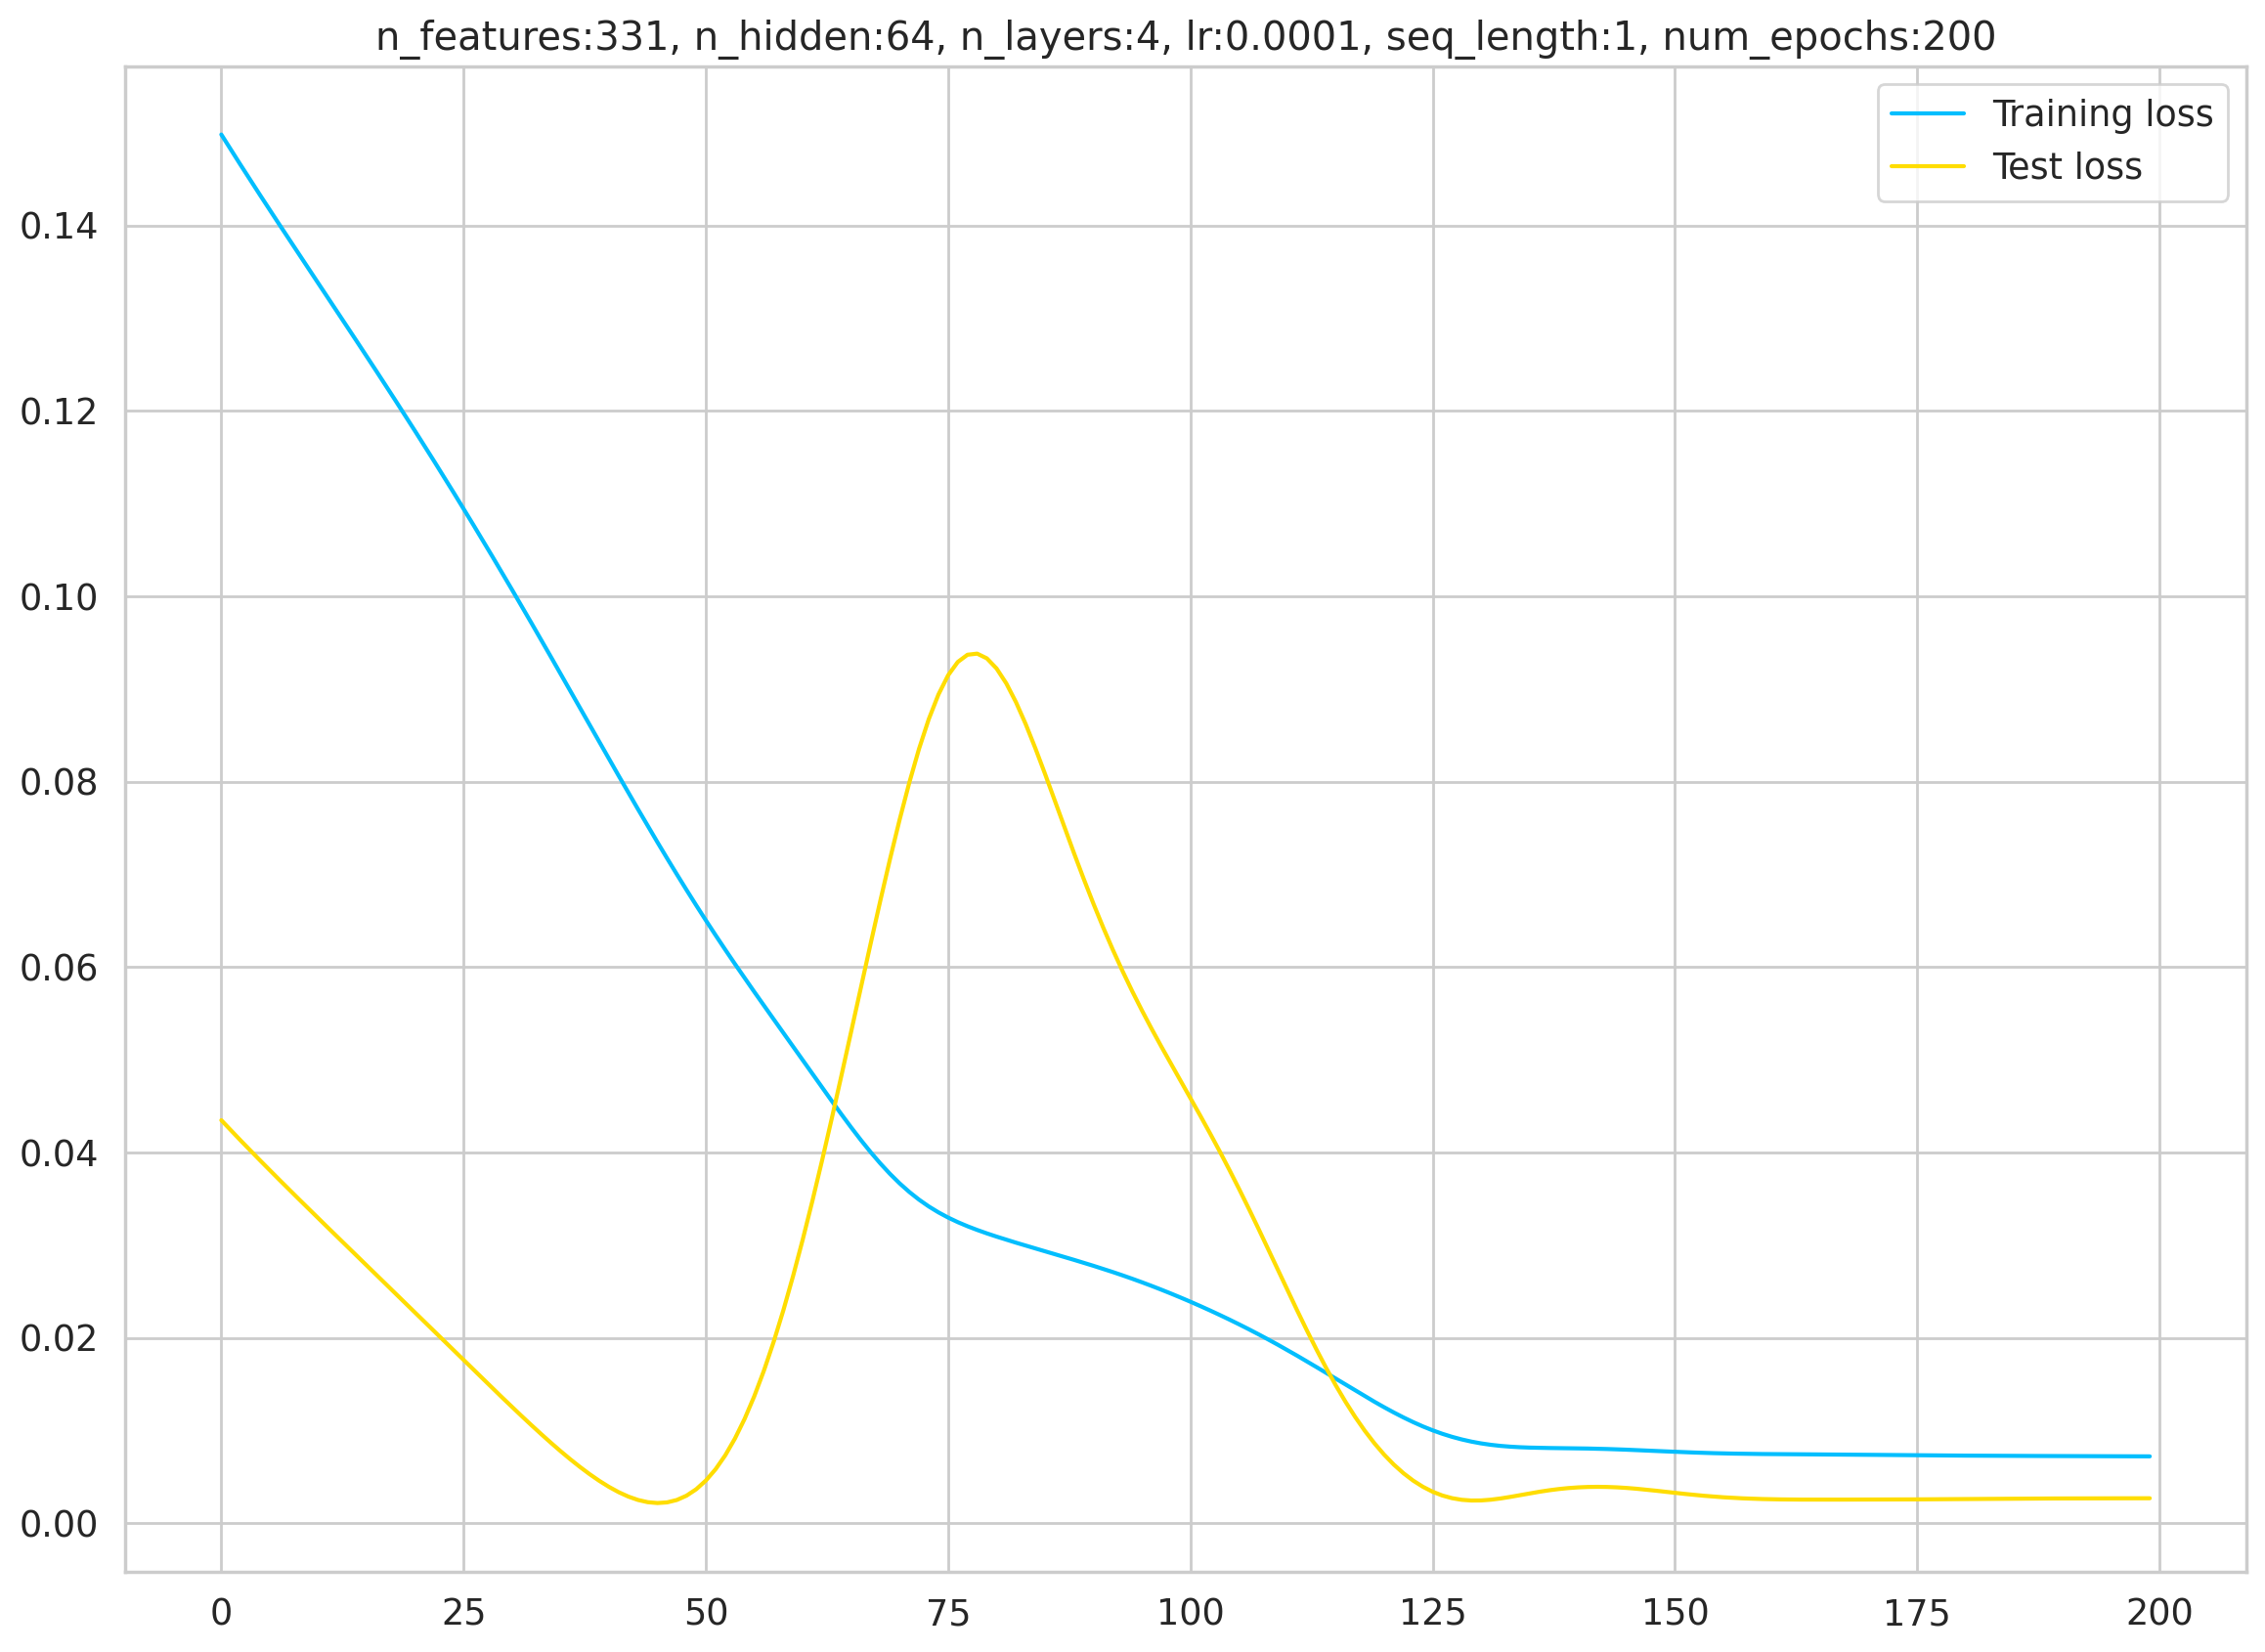

In [90]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

#### 7. 일일 케이스 예측

In [91]:
with torch.no_grad():
    
    preds = []
    for i in range(len(X_test)):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

In [92]:
preds

[0.07255754619836807,
 0.07351171225309372,
 0.07541453093290329,
 0.0770716592669487,
 0.07809632271528244,
 0.07842505723237991,
 0.07841920107603073,
 0.07810484617948532,
 0.07761958986520767,
 0.07674983888864517,
 0.07587897032499313,
 0.07502076774835587,
 0.07385606318712234,
 0.07241513580083847]

- X_test 값을 모델에 넣어 예측값 preds를 산출
- 소수점의 결과값들이 나오는데 이건 위에서 데이터를 스케일링 해줬기 때문

In [93]:
# Prediction value 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [94]:
pred_values

array([[4.64368296],
       [4.70474958],
       [4.82652998],
       [4.93258619],
       [4.99816465],
       [5.01920366],
       [5.01882887],
       [4.99871016],
       [4.96765375],
       [4.91198969],
       [4.8562541 ],
       [4.80132914],
       [4.72678804],
       [4.63456869]])

In [95]:
pred_values_ceiled  = list(pred_values.flatten())

In [96]:
# True value 역변환
true_values = yscaler.inverse_transform(y_test)[:, [-1]]

In [97]:
# 실제값 예측과 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

- 실제 y값 'True'와 모델로 부터 나온 예측값 'Pred'로 구성된 score_table
- 4월 22일 부터 5월5일까지의 실제값과 예측값

In [98]:
score_table

,True,Pred
0,6.0,4.643683
1,4.0,4.704750
2,2.0,4.826530
3,4.0,4.932586
4,10.0,4.998165
5,7.0,5.019204
6,12.0,5.018829
7,5.0,4.998710
8,4.0,4.967654
9,8.0,4.911990


- MSE와 RMSE를 생성
- score는 실제값과 예측값의 차이가 작을 수록 100에 가까워지는 점수

In [100]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 10.688652102111357, RMSE : 3.269350409807942, SCORE : 78.83435227304683


- 노란선이 실제값이고 빨간선이 예측값
- 실제 해외유입확진자의 경우에는 일일별 굴곡들이 있음

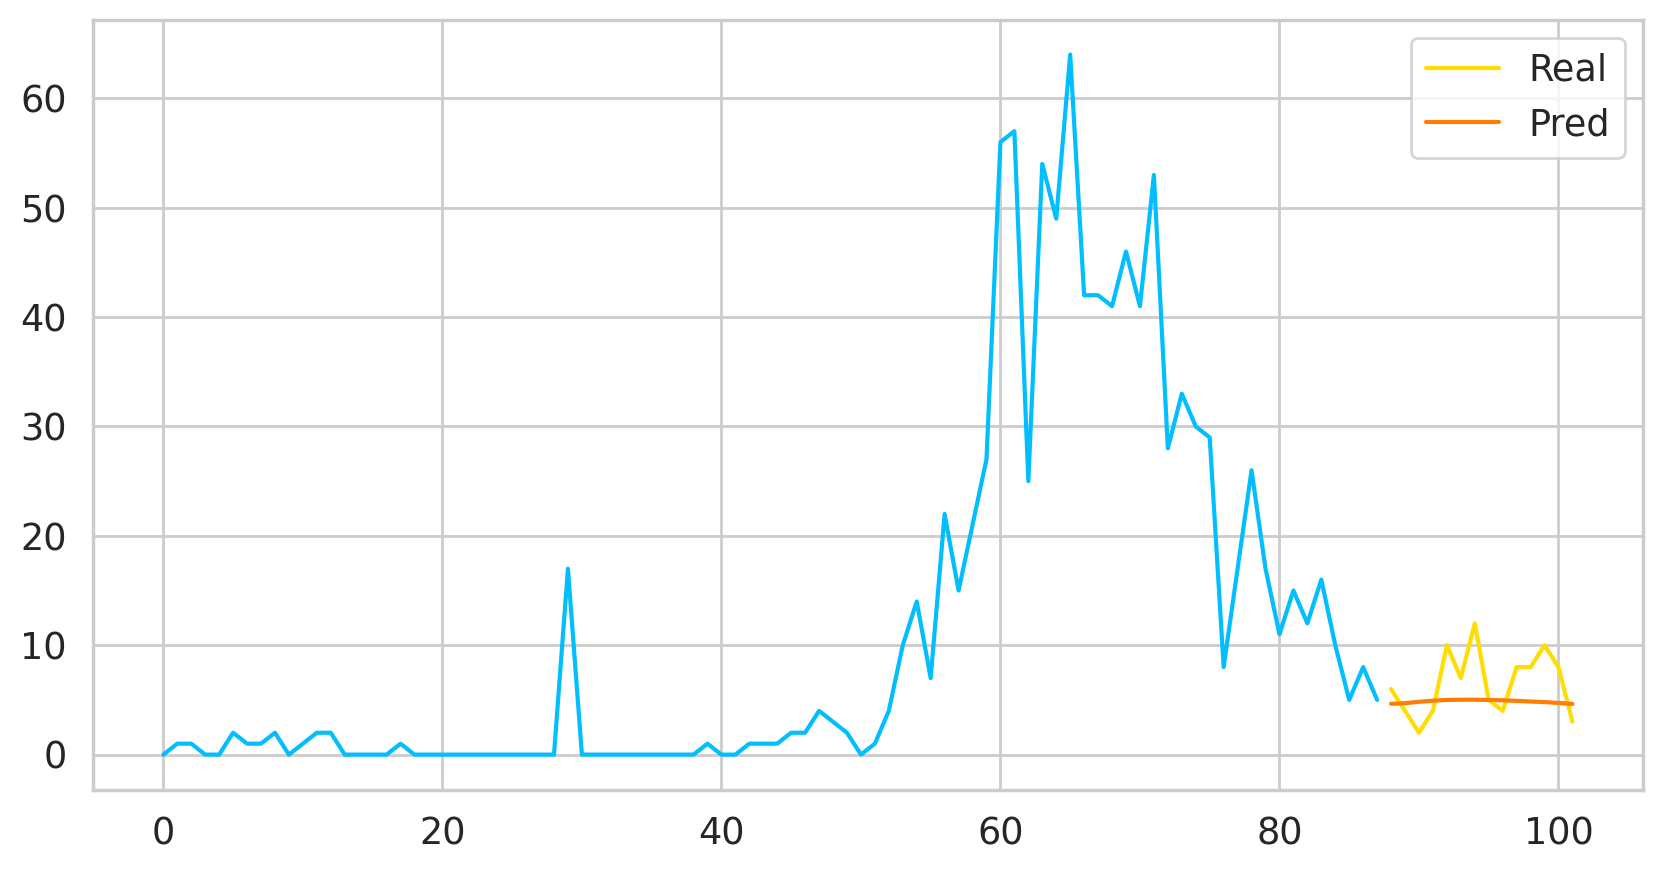

In [101]:
plt.figure(figsize=(10,5))
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
#plt.xlim(70)
plt.legend()

- PyTorch의 모델 확장자 형식인 .pth로 저장
- 모델의 파일명은 사용한 파라미터와 점수를 넣어 어떤 모델이었는지 구분 가능

In [103]:
# 모델 저장
PATH = './{6}_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs, score.round(2))

torch.save(model, PATH)

#### 8. 전체 데이터를 사용하여 미래 예측

- 동일하게 데이터를 전처리
- Train, Test를 나누는 것이 아닌 전체 데이터를 사용

In [104]:
X_all = df[X_cols]
y_all = df['target']

In [106]:
# MinMaxScaler 스케일링
scaler = MinMaxScaler()
# X scaler 
Xscaler = scaler.fit(X_all)
# Y scaler 
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용
X_all = Xscaler.fit_transform(X_all)
y_all = yscaler.fit_transform(y_all.values.reshape(-1,1))
y_all = y_all.flatten()

In [108]:
y_all

array([0.      , 0.015625, 0.015625, 0.      , 0.      , 0.03125 ,
       0.015625, 0.015625, 0.03125 , 0.      , 0.015625, 0.03125 ,
       0.03125 , 0.      , 0.      , 0.      , 0.      , 0.015625,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.265625,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.015625, 0.      , 0.      ,
       0.015625, 0.015625, 0.015625, 0.03125 , 0.03125 , 0.0625  ,
       0.046875, 0.03125 , 0.      , 0.015625, 0.0625  , 0.15625 ,
       0.21875 , 0.109375, 0.34375 , 0.234375, 0.328125, 0.421875,
       0.875   , 0.890625, 0.390625, 0.84375 , 0.765625, 1.      ,
       0.65625 , 0.65625 , 0.640625, 0.71875 , 0.640625, 0.828125,
       0.4375  , 0.515625, 0.46875 , 0.453125, 0.125   , 0.265625,
       0.40625 , 0.265625, 0.171875, 0.234375, 0.1875  , 0.25    ,
       0.15625 , 0.078125, 0.125   , 0.078125, 0.09375 , 0.062

In [107]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  (102, 331)
y_all :  (102,)


In [109]:
X_all = create_sequences1(X_all, seq_length)
y_all = create_sequences1(y_all, seq_length)
X_all = torch.from_numpy(np.array(X_all)).float()
y_all = torch.from_numpy(np.array(y_all)).float()

- DAYS_TO_PREDICT는 예측할 날짜의 수
- 14일을 예측하는 것이 목표였기 때문에 14로 설정

In [110]:
DAYS_TO_PREDICT = 14

with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]

In [111]:
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

- 14일 치의 미래 예측값
- 4명에서 1명까지 떨어짐
- 모델이 실제로 해외유입확진자의 감소를 학습을 한건지 아니면 딱히 예측에 대한 근거나 힘이 없어서 떨어질거라고 예측한건지는 알 수가 없음

In [112]:
import math

pred_values_ceiled = list(pred_values.flatten())
predicted_cases=pred_values_ceiled
predicted_cases

[4.548166751861572,
 4.438869953155518,
 4.242846965789795,
 3.933541774749756,
 3.5378994941711426,
 3.1072402000427246,
 2.689209461212158,
 2.3154854774475098,
 2.001107692718506,
 1.7486824989318848,
 1.5533461570739746,
 1.4067025184631348,
 1.2994379997253418,
 1.2227864265441895]

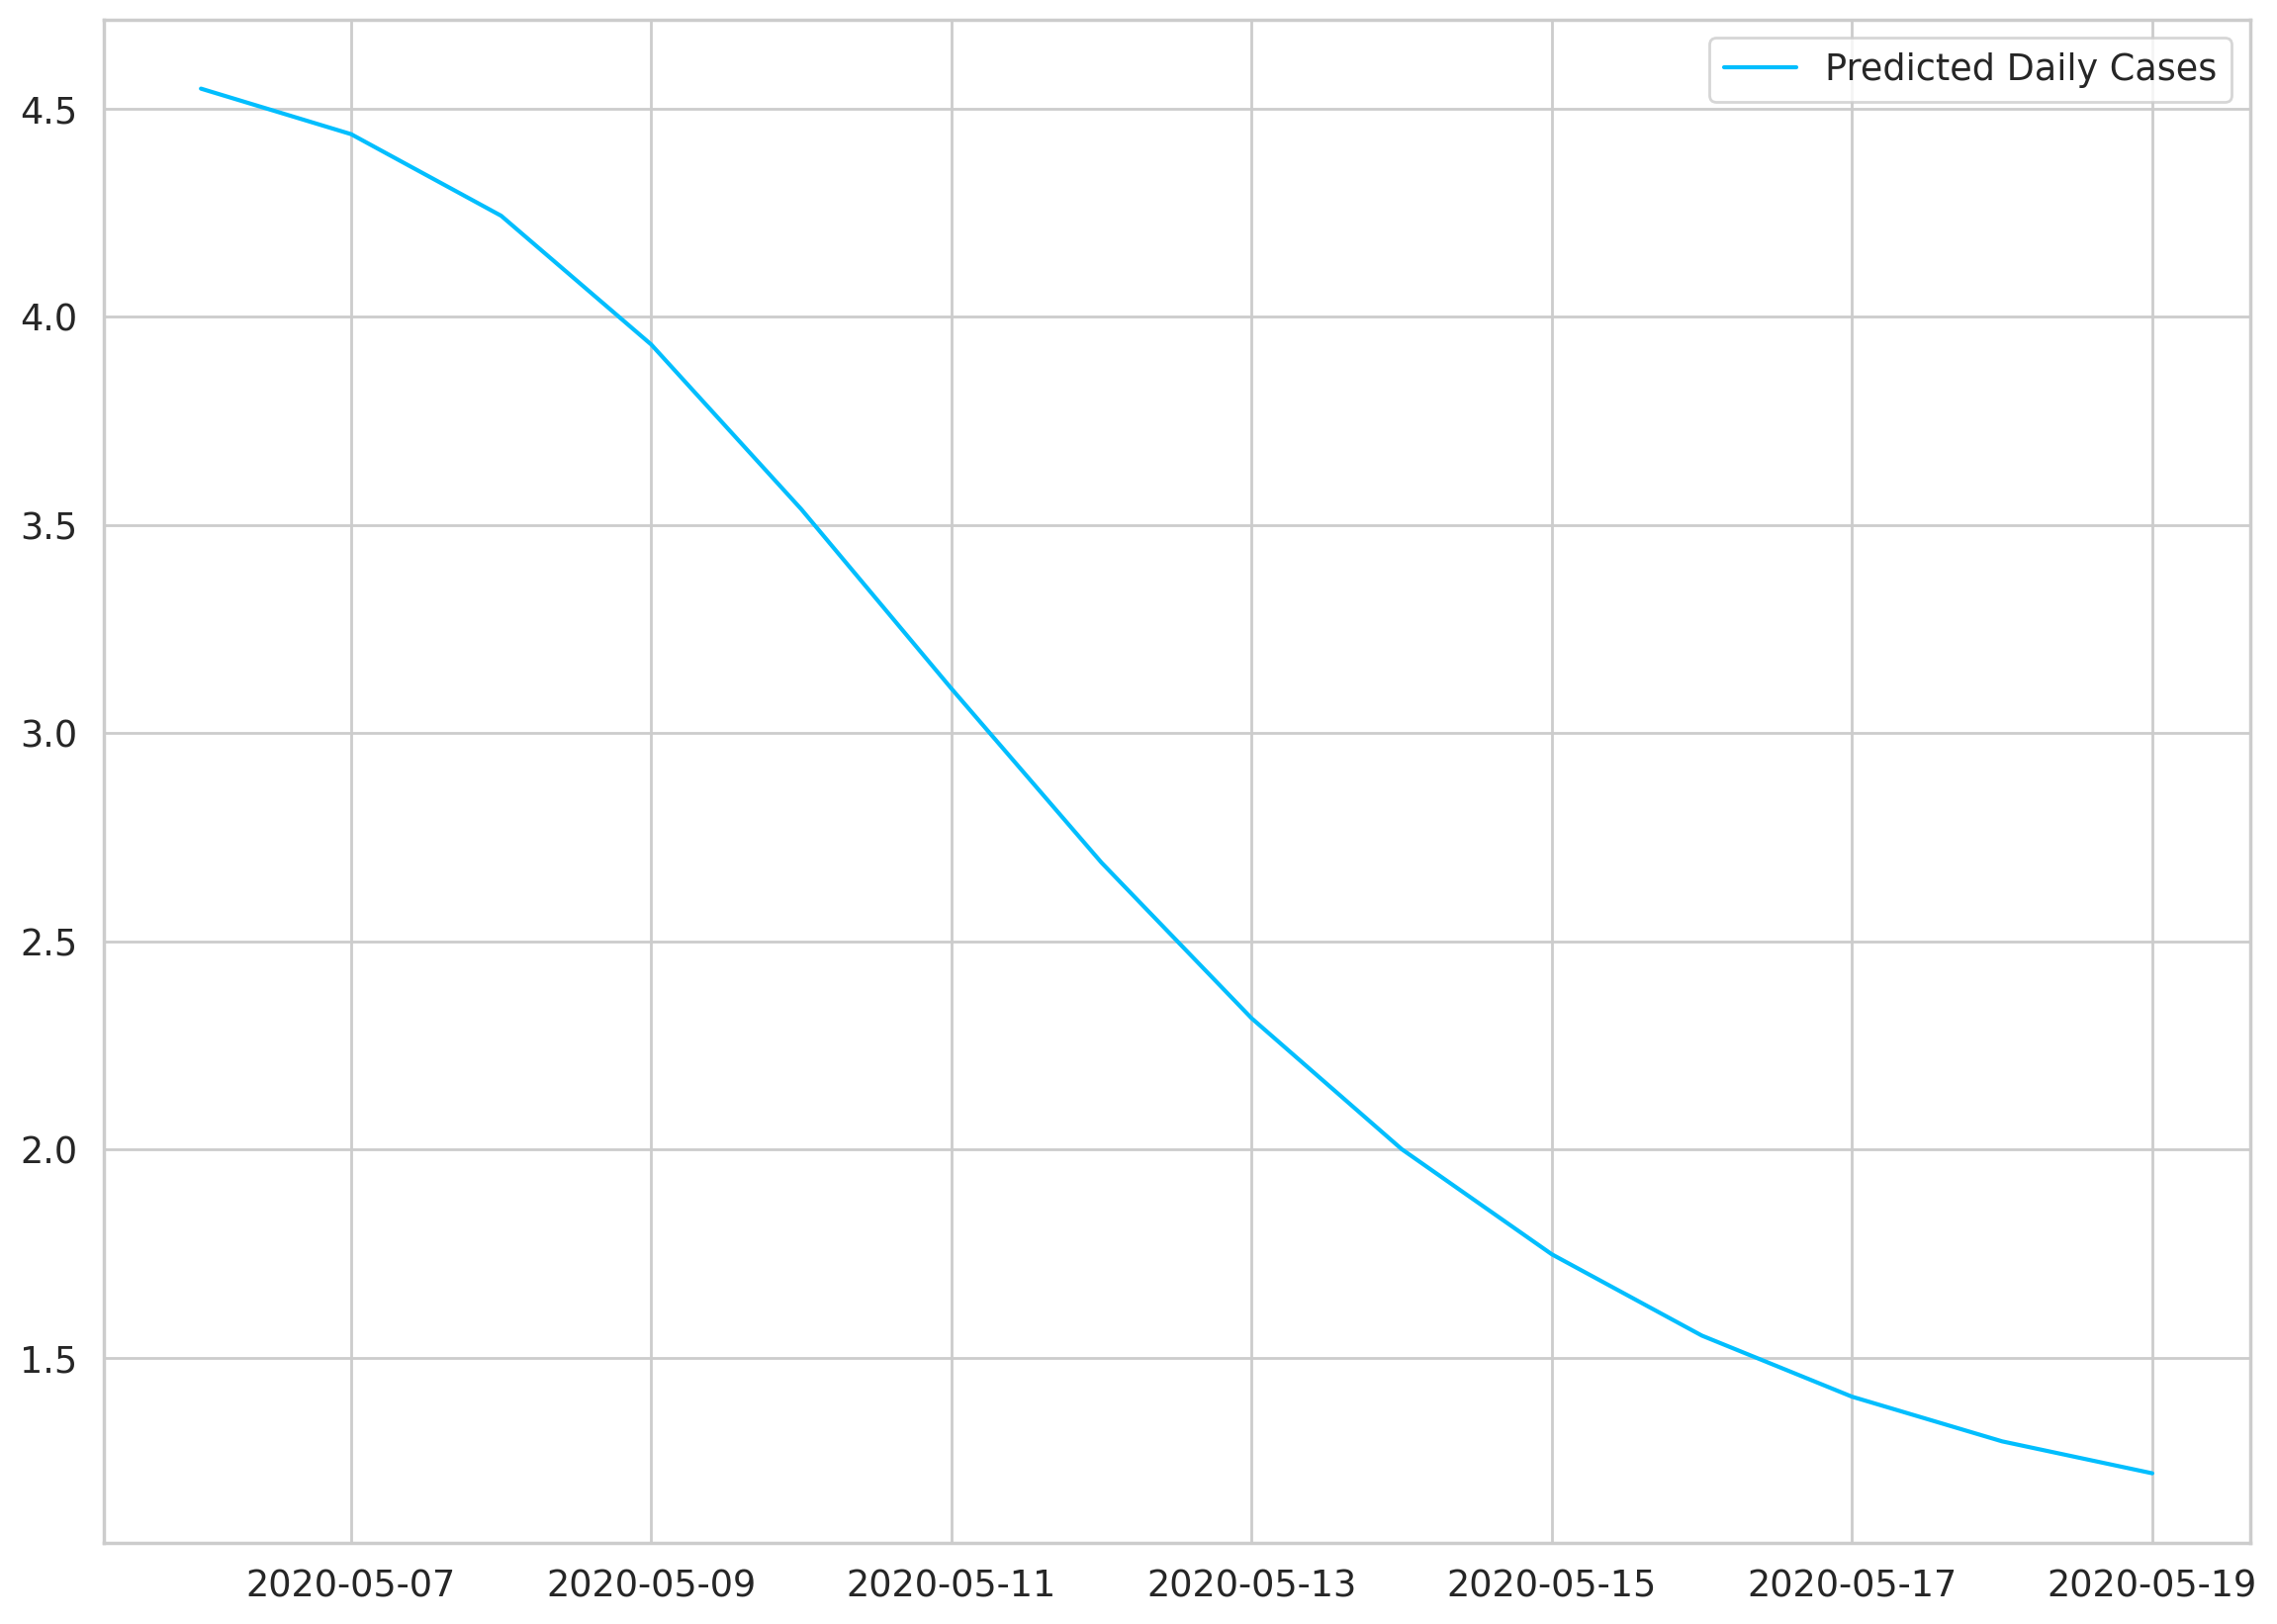

In [113]:
predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [116]:
predicted_cases

2020-05-06    4.548167
2020-05-07    4.438870
2020-05-08    4.242847
2020-05-09    3.933542
2020-05-10    3.537899
2020-05-11    3.107240
2020-05-12    2.689209
2020-05-13    2.315485
2020-05-14    2.001108
2020-05-15    1.748682
2020-05-16    1.553346
2020-05-17    1.406703
2020-05-18    1.299438
2020-05-19    1.222786
Freq: D, dtype: float64

In [114]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

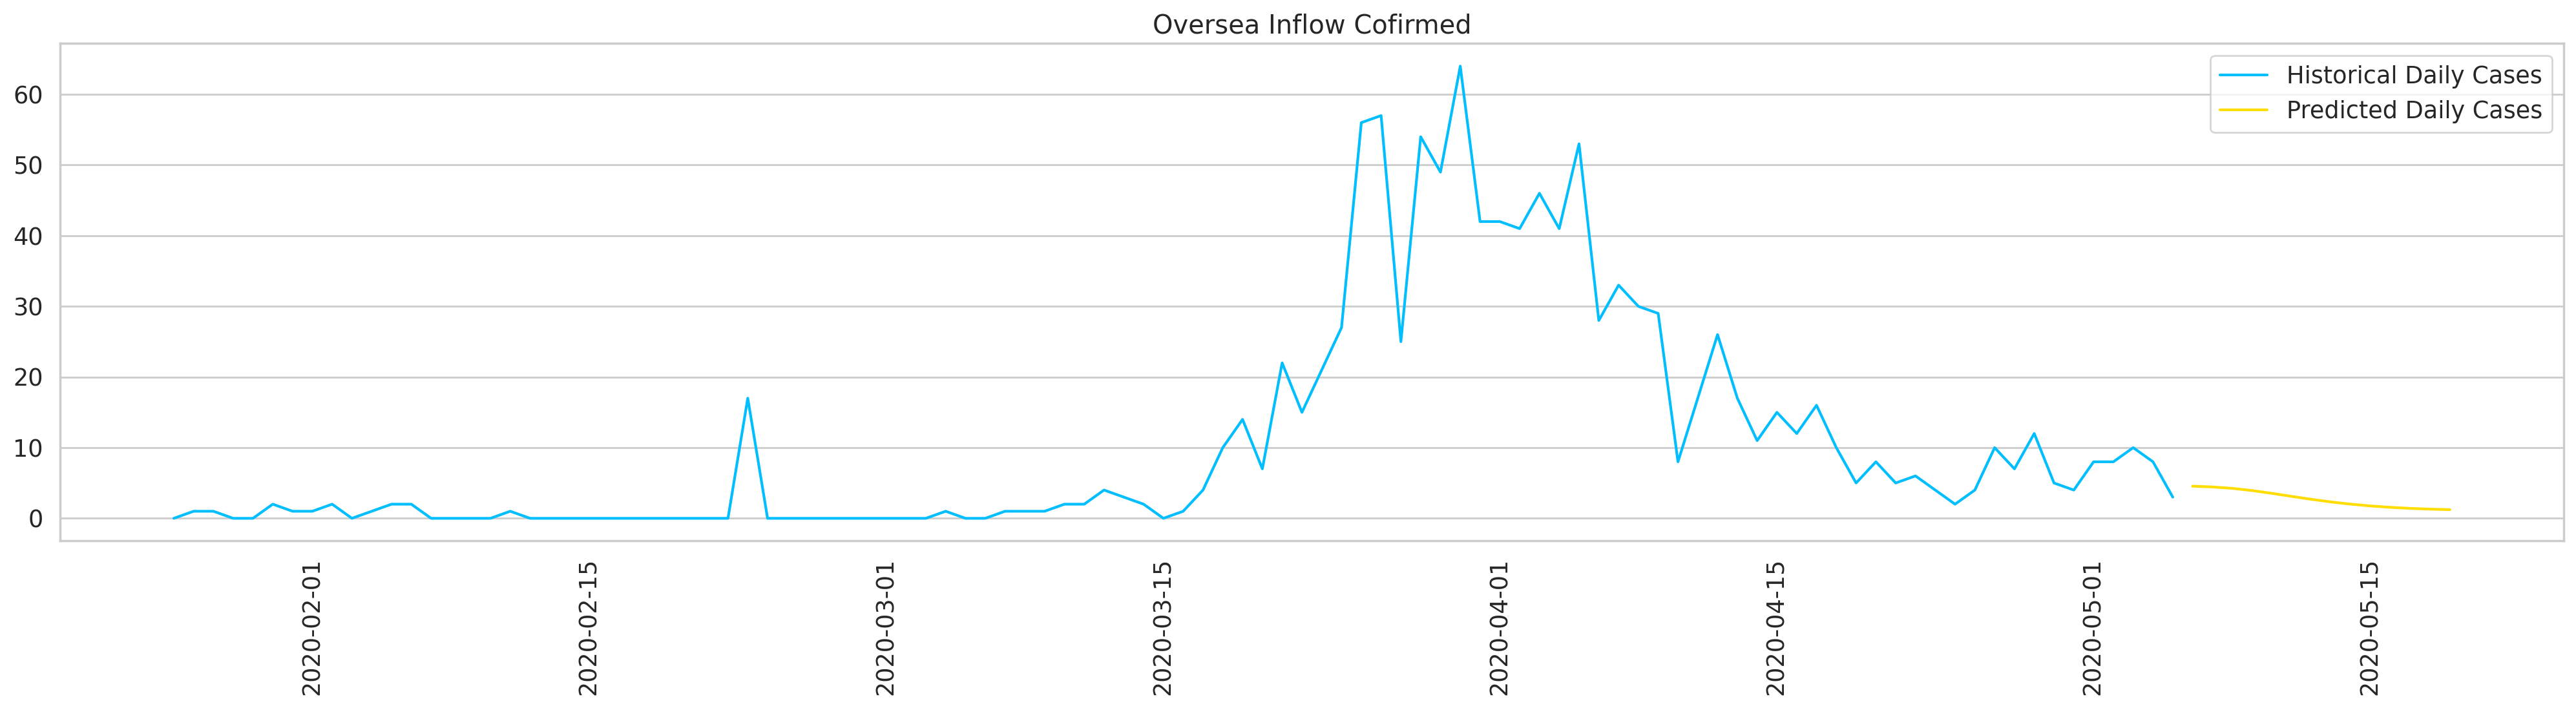

In [115]:
plt.figure(figsize=(25,5))
plt.plot(df['target'].astype(int), label='Historical Daily Cases')
plt.plot(preds_, label='Predicted Daily Cases')
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')
plt.legend()